# Tutorial OpenCL 

Requisitos:
- OpenCL 1.2
- Python 2.7.16 (pyopencl 2019.1.1, numpy 1.16.5, pandas 0.24.2)

In [2]:
#
# Matrix Multiplication Driver
#
# This is a driver program to test various ways of computing
# the product:
#                 C = A * B
#
# A and B are constant matrices, square and the order is
# set as a constant, ORDER (see definitions.py). This is so
# we can make a quick test of the multiplication result.
#
# History:   C++ version written by Tim Mattson, August 2010 
#            Modified by Simon McIntosh-Smith, September 2011
#            Modified by Tom Deakin and Simon McIntosh-Smith, October 2012
#            Ported to Python by Tom Deakin, July 2013
#            Ported to Jupyter Notebooks by Ricardo Menotti, May 2020

from time import time
import pyopencl as cl
import pandas as pd
import numpy
import os

# Order of the square matrices A, B and C
ORDER = 1024

# A elemetns are constant and equal to AVAL
AVAL = 3.0

# B elemetns are constant and equal to BVAL
BVAL = 5.0

# tolerance used in floating point comparisons
TOL = 0.001

# Max dim for NDRange
DIM = 2

# File to read/write results
FILENAME = 'results.csv'

# number of times to do each multiplication
COUNT = 10

# Creating Pandas DataFrame 
if os.path.isfile(FILENAME):
    df = pd.read_csv(FILENAME)
else:
    df = pd.DataFrame({"version": [], "execution_time": []})

#  Function to compute the matrix product (sequential algorithm, dot prod)
def seq_mat_mul_sdot(N, A, B, C):
    for i in range(N):
        for j in range(N):
            tmp = 0.0
            for k in range(N):
                tmp += A[i*N+k] * B[k*N+j]
            C[i*N+j] = tmp

#  Function to compute errors of the product matrix
def error(N, C):
   cval = float(N) * AVAL * BVAL
   errsq = 0.0
   for i in range(N):
       for j in range(N):
            err = C[i*N+j] - cval
            errsq += err * err
   return errsq;

# Function to analyze and output results
def results(N, C, run_time):
    mflops = 2.0 * N * N * N/(1000000.0* run_time)
    print run_time, "seconds at", mflops, "MFLOPS"
    errsq = error(N, C)
    if (errsq > TOL):
        print "Errors in multiplication:", errsq

# A[N][N], B[N][N], C[N][N]
N = ORDER;

# Number of elements in the matrix
size = N * N

# A matrix
h_A = numpy.empty(size).astype(numpy.float32)
h_A.fill(AVAL)

# B matrix
h_B = numpy.empty(size).astype(numpy.float32)
h_B.fill(BVAL)

# C matrix
h_C = numpy.empty(size).astype(numpy.float32)

Em Python o OpenCL é um pouco mais sucinto, por exemplo, basta as duas linhas abaixo para criar um fila associada a um dispositivo/contexto. 

In [3]:
# Set the environment variable to choose platform/device 
os.environ["PYOPENCL_CTX"] = '0:1'

# Setup OpenCL
context = cl.create_some_context()
queue = cl.CommandQueue(context)

# Reset host buffers - just to play it safe
h_A = numpy.empty(size).astype(numpy.float32)
h_A.fill(AVAL)
h_B = numpy.empty(size).astype(numpy.float32)
h_B.fill(BVAL)
h_C = numpy.empty(size).astype(numpy.float32)

# Create OpenCL buffers
d_a = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=h_A)
d_b = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=h_B)
d_c = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_C.nbytes)

Na versão mais simples, cada _work-item_ calcula um elemento da matriz:

In [4]:
#--------------------------------------------------------------------------------
# OpenCL matrix multiplication ... Naive
#--------------------------------------------------------------------------------

kernelsource = open("C_elem.cl").read()
print "<<<KERNEL SOURCE>>>\n", kernelsource
program = cl.Program(context, kernelsource).build()
mmul = program.mmul
mmul.set_scalar_arg_dtypes([numpy.int32, None, None, None])
print "\n===== OpenCL, matrix mult, C(i,j) per work item, order", N, "======\n"

# Do the multiplication COUNT times
for i in range(COUNT):
    h_C.fill(0.0)
    start_time = time()
    mmul(queue, (N, N), None, N, d_a, d_b, d_c)
    queue.finish()
    run_time = time() - start_time
    cl.enqueue_copy(queue, h_C, d_c)
    results(N, h_C, run_time)
    df = df.append(pd.DataFrame({"version": ["naive"], 
                                 "execution_time": [run_time]}))
df.to_csv(FILENAME, index = False, header = True)

<<<KERNEL SOURCE>>>

__kernel void mmul(
    const int N,
    __global float* A,
    __global float* B,
    __global float* C)
{
    int k;
    int i = get_global_id(0);
    int j = get_global_id(1);
    float tmp;
    if ((i < N) && (j < N))
    {
        tmp = 0.0;
        for (k = 0; k < N; k++)
            tmp += A[i*N+k] * B[k*N+j];
        C[i*N+j] = tmp;
    }
}


===== OpenCL, matrix mult, C(i,j) per work item, order 1024 ======

0.371258974075 seconds at 5784.32791651 MFLOPS
0.365642786026 seconds at 5873.17384637 MFLOPS
0.361247062683 seconds at 5944.6397489 MFLOPS
0.272753953934 seconds at 7873.33645224 MFLOPS
0.360718011856 seconds at 5953.35851667 MFLOPS
0.365295886993 seconds at 5878.75123828 MFLOPS
0.361917972565 seconds at 5933.61980004 MFLOPS
0.362024068832 seconds at 5931.88086893 MFLOPS
0.36127614975 seconds at 5944.16113405 MFLOPS
0.360991001129 seconds at 5948.85645704 MFLOPS


Nesta versão, cada _work-item_ calcula uma linha da matriz:

In [5]:
#--------------------------------------------------------------------------------
# OpenCL matrix multiplication ... C row per work item
#--------------------------------------------------------------------------------

kernelsource = open("C_row.cl").read()
print "<<<KERNEL SOURCE>>>\n", kernelsource
program = cl.Program(context, kernelsource).build()
mmul = program.mmul
mmul.set_scalar_arg_dtypes([numpy.int32, None, None, None])
print "\n===== OpenCL, matrix mult, C row per work item, order", N, "======\n"
# Do the multiplication COUNT times
for i in range(COUNT):
    h_C.fill(0.0)
    start_time = time()
    mmul(queue, (N,), (ORDER/16,), N, d_a, d_b, d_c)
    queue.finish()
    run_time = time() - start_time
    cl.enqueue_copy(queue, h_C, d_c)
    results(N, h_C, run_time)
    df = df.append(pd.DataFrame({"version": ["C row per work item"], 
                                 "execution_time": [run_time]}))
df.to_csv(FILENAME, index = False, header = True)

<<<KERNEL SOURCE>>>

__kernel void mmul(
    const int N,
    __global float* A,
    __global float* B,
    __global float* C)
{
    int k, j;
    int i = get_global_id(0);
    float tmp;
    if (i < N) {
        for (j = 0; j < N; j++) {
            tmp = 0.0;
            for (k = 0; k < N; k++)
                tmp += A[i*N+k] * B[k*N+j];
            C[i*N+j] = tmp;
        }
    }
}


===== OpenCL, matrix mult, C row per work item, order 1024 ======

0.787873029709 seconds at 2725.67224289 MFLOPS
0.796849966049 seconds at 2694.9661034 MFLOPS
0.791598081589 seconds at 2712.8459479 MFLOPS
0.787890911102 seconds at 2725.61038304 MFLOPS
0.772300958633 seconds at 2780.63056117 MFLOPS
0.79146194458 seconds at 2713.31257644 MFLOPS
0.790559053421 seconds at 2716.41142898 MFLOPS
0.790224075317 seconds at 2717.56292307 MFLOPS
0.790154218674 seconds at 2717.80317974 MFLOPS
0.791073083878 seconds at 2714.64633517 MFLOPS


Agora fazemos o mesmo, mas antes copiamos uma linha da matriz A em memória privada 

In [6]:
#--------------------------------------------------------------------------------
# OpenCL matrix multiplication ... C row per work item, A row in private memory
#--------------------------------------------------------------------------------

kernelsource = open("C_row_priv.cl").read()
print "<<<KERNEL SOURCE>>>\n", kernelsource
program = cl.Program(context, kernelsource).build()
mmul = program.mmul
mmul.set_scalar_arg_dtypes([numpy.int32, None, None, None])
print "\n===== OpenCL, matrix mult, C row, A row in priv mem, order", N, "======\n"
# Do the multiplication COUNT times
for i in range(COUNT):
    h_C.fill(0.0)
    start_time = time()
    mmul(queue, (N,), (ORDER/16,), N, d_a, d_b, d_c)
    queue.finish()
    run_time = time() - start_time
    cl.enqueue_copy(queue, h_C, d_c)
    results(N, h_C, run_time)
    df = df.append(pd.DataFrame({"version": ["C row, A row in priv mem"], 
                                 "execution_time": [run_time]}))
df.to_csv(FILENAME, index = False, header = True)

<<<KERNEL SOURCE>>>

__kernel void mmul(
    const int N,
    __global float* A,
    __global float* B,
    __global float* C)
{
    int k, j;
    int i = get_global_id(0);
    float Awrk[1024];
    float tmp;
    if (i < N) {
        for (k = 0; k < N; k++)
            Awrk[k] = A[i*N+k];

        for (j = 0; j < N; j++) {
            tmp = 0.0f;
            for (k = 0; k < N; k++)
                tmp += Awrk[k] * B[k*N+j];
            C[i*N+j] = tmp;
        }
    }
}


===== OpenCL, matrix mult, C row, A row in priv mem, order 1024 ======

0.796367168427 seconds at 2696.59992669 MFLOPS
0.786025047302 seconds at 2732.08042844 MFLOPS
0.780080080032 seconds at 2752.90153276 MFLOPS
0.777578830719 seconds at 2761.7568318 MFLOPS
0.77804017067 seconds at 2760.11924442 MFLOPS
0.791255950928 seconds at 2714.01895364 MFLOPS
0.782909154892 seconds at 2742.95380835 MFLOPS
0.775856018066 seconds at 2767.88939957 MFLOPS
0.717663049698 seconds at 2992.32857105 MFLOPS
0.778812170029 seconds at 2757

Agora vamos usar a memória local para a coluna B da matriz a ser calculada 

In [7]:
#--------------------------------------------------------------------------------
# OpenCL matrix multiplication ... C row per work item, A row private, B col local
#--------------------------------------------------------------------------------

kernelsource = open("C_row_priv_bloc.cl").read()
print "<<<KERNEL SOURCE>>>\n", kernelsource
program = cl.Program(context, kernelsource).build()
mmul = program.mmul
mmul.set_scalar_arg_dtypes([numpy.int32, None, None, None, None])
print "\n===== OpenCL, mat mult, C row, priv A, B cols loc, order", N, "======\n"
# Do the multiplication COUNT times
for i in range(COUNT):
    h_C.fill(0.0)
    start_time = time()
    localmem = cl.LocalMemory(numpy.dtype(numpy.float32).itemsize * N)
    mmul(queue, (N,), (ORDER/16,), N, d_a, d_b, d_c, localmem)
    queue.finish()
    run_time = time() - start_time
    cl.enqueue_copy(queue, h_C, d_c)
    results(N, h_C, run_time)
    df = df.append(pd.DataFrame({"version": ["C row, priv A, B cols loc"], 
                                 "execution_time": [run_time]}))
df.to_csv(FILENAME, index = False, header = True)

<<<KERNEL SOURCE>>>

__kernel void mmul(
    const int N,
    __global float* A,
    __global float* B,
    __global float* C,
    __local float* Bwrk)
{
    int k, j;
    int i    = get_global_id(0);
    int iloc = get_local_id(0);
    int nloc = get_local_size(0);
    float Awrk[1024];
    float tmp;
    if (i < N) {
        for (k = 0; k < N; k++)
            Awrk[k] = A[i*N+k];

        for (j = 0; j < N; j++) {
            barrier(CLK_LOCAL_MEM_FENCE);
            for (k = iloc; k < N; k += nloc)
                Bwrk[k] = B[k*N+j];
            barrier(CLK_LOCAL_MEM_FENCE);
            tmp = 0.0f;
            for (k = 0; k < N; k++)
                tmp += Awrk[k] * Bwrk[k];
            C[i*N+j] = tmp;
            barrier(CLK_LOCAL_MEM_FENCE);
        }
    }
}


===== OpenCL, mat mult, C row, priv A, B cols loc, order 1024 ======

0.453321218491 seconds at 4737.22287951 MFLOPS
0.447901010513 seconds at 4794.54968306 MFLOPS
0.429316043854 seconds at 5002.10434421 MFLOPS
0.3570809364

Por fim, temos uma versão que calcula por blocos:

In [8]:
#--------------------------------------------------------------------------------
# OpenCL matrix multiplication ... blocked
#--------------------------------------------------------------------------------

kernelsource = open("C_block_form.cl").read()
print "<<<KERNEL SOURCE>>>\n", kernelsource
program = cl.Program(context, kernelsource).build()
mmul = program.mmul
mmul.set_scalar_arg_dtypes([numpy.int32, None, None, None, None, None])
print "\n==== Parallel matrix mult (blocked), order {0} on device ======\n".format(N)
# Do the multiplication COUNT times
for i in range(COUNT):
    h_C.fill(0.0)
    start_time = time()
    # Work-group computes a block of C. This size is also set
    # in a #define inside the kernel function. Note this blocksize
    # must evenly divide the matrix order
    blocksize = 16
    A_block = cl.LocalMemory(numpy.dtype(numpy.float32).itemsize * blocksize * blocksize)
    B_block = cl.LocalMemory(numpy.dtype(numpy.float32).itemsize * blocksize * blocksize)
    mmul(queue, (N,N), (blocksize,blocksize), N,
        d_a, d_b, d_c, A_block, B_block)
    queue.finish()
    run_time = time() - start_time
    cl.enqueue_copy(queue, h_C, d_c)
    results(N, h_C, run_time)
    df = df.append(pd.DataFrame({"version": ["blocked"], 
                                 "execution_time": [run_time]}))
df.to_csv(FILENAME, index = False, header = True)

<<<KERNEL SOURCE>>>
//-------------------------------------------------------------
//
//  PROGRAM: Blocked Matrix Multipliplication kernel
//
//  PURPOSE: Computes an element of the proudct matrix
//
//              C = A * B
//
//           Using the well known blocked algorithm.  
//
//           To derive this algorithm, start with the naive
//           triply nested loop algorithm with a dot product 
//           for each element of C.  Decompose each loop 
//           into blocks of size blcksz.  This gives you 6
//           nested loops with three loops over blocks
//           and three loops over indices inside the blocks.
// 
//           Rearrange the loops to put the 3 loops over blocks 
//           at the outermost loops of the loop nest.  You'll
//           see that the three "inner" loops are just the 
//           regular matrix product between blocks.
//
//           The algorithms is simple.  Keeping all the indices
//           straight is not.  We will use the 

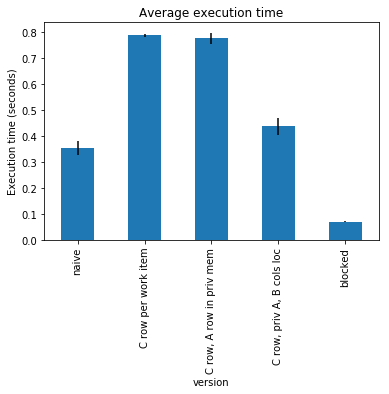

In [10]:
# Plot results
df = pd.read_csv(FILENAME)
by_version = df.groupby(by="version", sort=False)
avg_time = by_version.mean()
std = by_version.std()
plt = avg_time.plot(legend=False, kind="bar", yerr=std);
plt.set_title("Average execution time");
plt.set_ylabel("Execution time (seconds)");
plt.get_figure().savefig("results.pdf")

# Referências

* [Hands On OpenCL](http://handsonopencl.github.io/)